In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import librosa

import pickle

In [2]:
with open('../data/pickle/preprocessing.pkl', 'rb') as f:
    pre = pickle.load(f)

In [3]:
df = pd.read_csv('../data/aggregated_audio.csv')

X = pre.transform(df[[str(x) for x in range(256)]].values)

In [4]:
score = []
for k in range(2, 15):
    km = KMeans(
        n_clusters = k,
        n_init = 30,
        random_state = 42
    ).fit(X)

    sil = silhouette_score(X, km.labels_)

    score.append((k, sil))

score_df = pd.DataFrame(score, columns = ['k', 'sil'])

score_df.sort_values(
    by = ['sil'], ascending = False
    ).head()

,k,sil
0,2,0.274932
1,3,0.251991
2,4,0.183667
3,5,0.172525
4,6,0.142781


We have fairly poor performance in terms of silhouette score but let's take a look at the 3-Means model. It has a slightly lower silhouette score than the 2-Means model but ideally we want smaller clusters and it does score much higher than all the other models.

In [5]:
km = KMeans(
        n_clusters = 3,
        n_init = 30,
        random_state = 42
    ).fit(X)

df['labels'] = km.labels_
df['labels'].value_counts()

0    42541
2    24090
1    13309
Name: labels, dtype: int64

Not the most even split but none of the clusters are too small, though we'd like the first cluster to be a bit smaller ideally. Let's take a quick look at how the clusters are separating our data before we make a final decision.

In [6]:
label_dist = []
for genre in df['genre_top'].unique():
    label_dist.append(df[df['genre_top'] == genre]['labels'].value_counts())

pd.DataFrame(label_dist, index = df['genre_top'].unique())[[0, 1, 2]]

,0,1,2
Hip-Hop,5118,149,4703
Pop,6301,846,2853
Folk,3832,2443,3725
Experimental,4896,2892,2202
Rock,8537,581,872
International,4669,1024,4307
Electronic,5861,823,3306
Instrumental,3327,4551,2122


In [7]:
df.groupby('labels')[['0', '1', '2']].agg(['mean', 'std']).T

labels          0          1          2
0 mean   1.218453 -15.942542  -4.876400
  std   13.046498  16.344409  15.700761
1 mean  10.112536  -9.024407   2.578999
  std   12.233211  16.828377  15.920578
2 mean  13.358645  -4.565828   5.588254
  std   10.475193  16.461246  14.123791

Our cluster isn't particularly separating our data well in terms of genre but in the end the main goal here is to separate our data just enough that it can help reduce computation time later on. In terms of specific genre trends we do see that our second cluster mostly excludes Hip-Hop, Pop, and Electronic and that our first cluster includes the lion's share of Rock songs. 

We will proceed with this 3-Means model because we don't really mind that our clusters are diverse in terms of genre and we do see that the clusters are decently different across the first 3 principal components. Ideally, we would have better separation but having very diverse clusters could also help us find novel recommendations so we aren't going to stress a huge amount about it.

In [11]:
import librosa


In [12]:
song, sr = librosa.load('../data/12 Dilip - Pulse.wav')

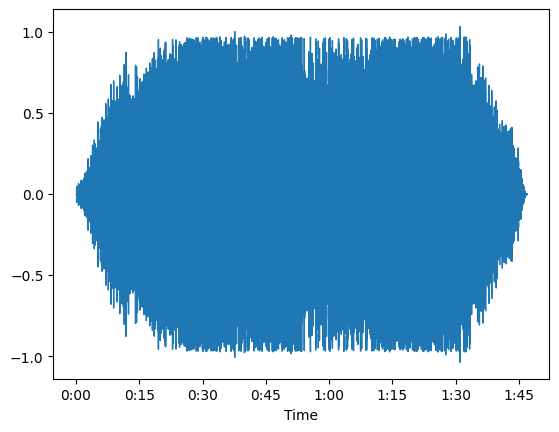

In [15]:
librosa.display.waveshow(song);

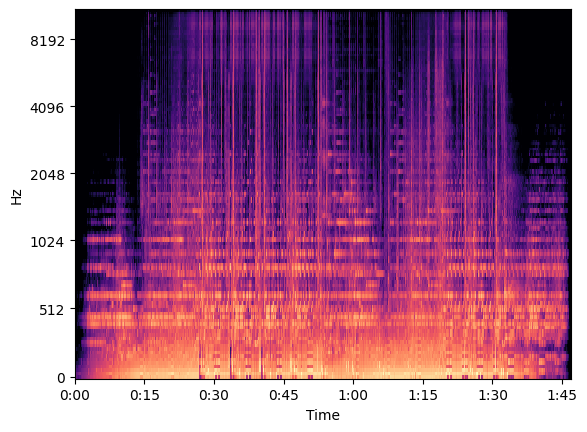

In [28]:
dianagram = librosa.feature.melspectrogram(y = song, sr = sr)

librosa.display.specshow(librosa.power_to_db(dianagram, ref = np.max), x_axis = 'time', y_axis = 'mel');

In [30]:
dianagram.T.shape

(4602, 128)

In [34]:
4602 // 129

35

In [29]:
with open('../data/pickle/kmeans.pkl', 'wb') as f:
    pickle.dump(km, f)